# <center> Прототип решения по Треку 3:</center> <center> «Предсказание вероятности возникновения ДТП»</center>

## Постановка задачи

Разработать алгоритм прогнозирующий наиболее вероятную категорию события дорожно-транспортного происшествия (далее по тексту «ДТП»):

>1. ДТП не произойдет
>1. ДТП произойдет без пострадавших
>1. ДТП произойдет с пострадавшими

Данные для обучения — информация о ДТП от ГИБДД и ВНИИ ГОЧС, а также дополнительные данные по интенсивности движения, метеоусловиях на участках дороги и др. В качестве федеральных автомобильных дорог рассматриваются М-8 «Холмогоры» и Р-21 «Кола».

## Прототип решения

In [1]:
from notebook_utils import add_project_path
add_project_path()
%load_ext autoreload
%autoreload 2

%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import re
import functools
from geopy.distance import geodesic
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
import numpy as np

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

### 1. Подготовка датасета для обучения модели

In [3]:
df = pd.read_csv('../data_raw/train.csv', usecols=[0, 1, 2, 9, 10], parse_dates=['datetime'])
df = df.sort_values('datetime', ascending=True)
df.reset_index(drop=True, inplace=True)
df.head(2)

,datetime,road_id,road_km,data_source,target
0,2012-01-01 12:00:00,14,1276,gochs,2
1,2012-01-01 22:00:00,9,278,gochs,2


#### Тренеровочный датасет (`train.csv`):
> 1. **datetime** - дата события в формате `yyyy-MM-dd hh-mm-ss`
> 1. **road_id** - код автодороги, принимает одно из трех значений:
>    * 5 — М-4 (E115) “Дон” Москва - Новороссийск;
>    * 9 — М-8 (E115) “Холмогоры” Москва - Архангельск через Ярославль, Вологду;
>    * 4 — М-18 / Р-21 (E105) “Кола” С.Петербург - Мурманск через Петрозаводск.
> 1. **road_km** - км участка на котором произошло ДТП
> 1. **data_source** - источник данных события. В датасете атрибут принимает одно из двух значений:
>    * gibdd - ГИБДД;
>    * gochs - МЧС.
> 1. **target** - целевой признак является ли событие ДТП. В датасете атрибут принимает одно из четырех значений:
>    * 1 - ДТП без пострадавших;
>    * 2 - ДТП с пострадавшими;
>    * 3 - ЧС (объявляется от 5 погибших и/или 10 пострадавших)* в тестовой выборке события отсутствуют0 - событие не является ДТП;

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109737 entries, 0 to 109736
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   datetime     109737 non-null  datetime64[ns]
 1   road_id      109737 non-null  int64         
 2   road_km      109737 non-null  int64         
 3   data_source  109737 non-null  object        
 4   target       109737 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 4.2+ MB


In [5]:
start = df.datetime.min()
end = df.datetime.max()
print("Временной интервал наблюдений: от {} до {}".format(start,end))
gibdd = df.groupby('data_source')['road_id'].count()[0]
mchs = df.groupby('data_source')['road_id'].count()[1]
print("Кол-во наблюдений по источникам данных: ГИБДД - {}, МЧС {}".format(gibdd,mchs))

Временной интервал наблюдений: от 2012-01-01 12:00:00 до 2021-04-05 11:00:00
Кол-во наблюдений по источникам данных: ГИБДД - 94678, МЧС 15059


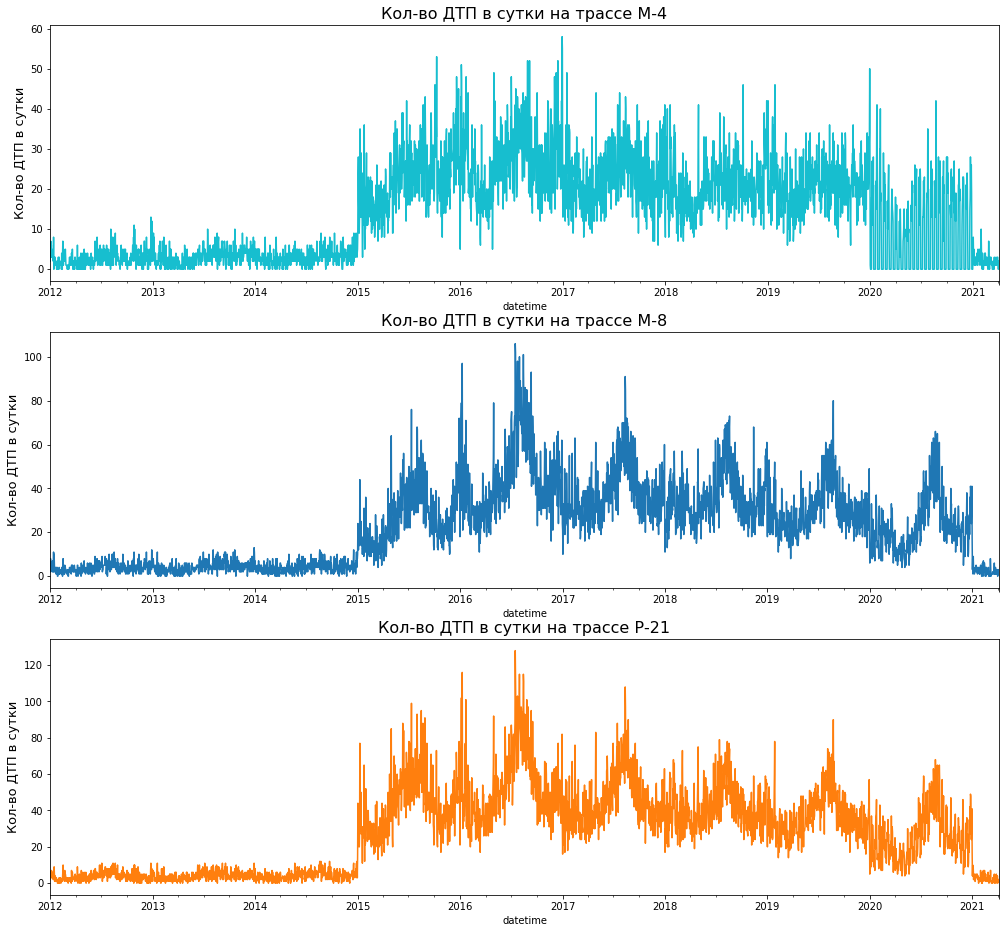

In [6]:
# распределение ДТП в расрезе трех трасс
fig, ax = plt.subplots(figsize=(17,16), ncols=1, nrows=3)

road_5 = df.drop(df[df["road_id"]==5].index)
road_9 = df.drop(df[df["road_id"]==9].index)
road_14 = df.drop(df[df["road_id"]==14].index)

dtp_day_5 = road_5[['datetime', 'target']].set_index('datetime').resample('D').count()['target']
dtp_day_9 = road_9[['datetime', 'target']].set_index('datetime').resample('D').count()['target']
dtp_day_14 = road_14[['datetime', 'target']].set_index('datetime').resample('D').count()['target']

dtp_day_5.plot(color='tab:cyan', ax=ax[0]).set_ylabel('Кол-во ДТП в сутки', fontsize=13)
dtp_day_9.plot(color='tab:blue', ax=ax[1]).set_ylabel('Кол-во ДТП в сутки', fontsize=13)
dtp_day_14.plot(color='tab:orange', ax=ax[2]).set_ylabel('Кол-во ДТП в сутки', fontsize=13)

ax[0].set_title('Кол-во ДТП в сутки на трассе М-4',loc='center', fontsize=16)
ax[1].set_title('Кол-во ДТП в сутки на трассе М-8',loc='center', fontsize=16)
ax[2].set_title('Кол-во ДТП в сутки на трассе Р-21',loc='center', fontsize=16)
plt.show()

На временном интервале от 2012-01-01 до 2021-04-05 можно наблюдать разброс в количестве аварий по дням в разрезе лет: так, с 2016 года суточный показатель ДТП значительно больше по каждой из рассматриваемых трасс. Такой разброс объясняетсся различной представленностью данных МЧС (15059) и ГИБДД (94678 наблюдений) с отсутствием последних на интервале 2012-2015 гг. (см. график ниже). 

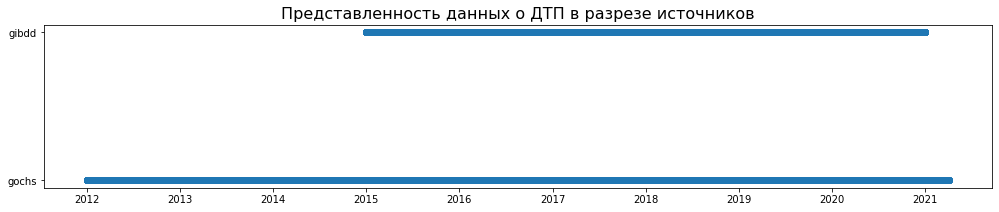

In [7]:
fig, ax = plt.subplots(figsize=(17,3))
plt.scatter(road_9['datetime'], road_9['data_source'])
ax.set_title('Представленность данных о ДТП в разрезе источников',loc='center', fontsize=16)
plt.show()

Для дальнейшего обучения модели **выберем данные о ДТП по трассе М-8**. Рассмотрим ситуацию для значений переменной `target` 1 и 2, исключив ЧС. Выберем период наблюдения с 2019-01-01 по 2020-12-31, заполним промежутки между наблюдениями на всем временном интервале нулевыми значениями с шагом в один час, присвоив значения 0 (событие не является ДТП) переменной `target`, и обогатим исходную выборку переменными из других датасетов.

In [8]:
# исключение из выборки ЧС и определение временного интервала
condition1 = (road_9["target"]!=3)
condition2 = (road_9['datetime'] > '2019-01-01')
condition3 = (road_9['datetime'] < '2020-12-31')
road_9 = road_9[(condition1 & condition2 & condition3)]
road_9 = road_9[['datetime','road_km','target']]
road_9.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19514 entries, 82782 to 109371
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  19514 non-null  datetime64[ns]
 1   road_km   19514 non-null  int64         
 2   target    19514 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 609.8 KB


#### Обагащение выборки переменными из датасетов `traffic.csv`, `repair.csv`

In [10]:
traffic = pd.read_csv('../data_raw/traffic.csv', usecols=[0, 1, 2, 4, 5, 9, 10, 11], parse_dates=['datetime'])
repair = pd.read_csv('../data_raw/repair.csv', parse_dates=['datetime'])

In [11]:
# фильтр датасетов traffic.csv, repair.csv по заданным уловиям
condition1 = (repair["road_id"]==9)
condition2 = (repair['datetime'] == '2019-01-01') | (repair['datetime'] == '2020-01-01')
repair = repair[condition1 & condition2]

condition1 = (traffic["road_id"]==9)
condition2 = (traffic['datetime'] > '2020-01-01')
condition3 = (traffic['datetime'] < '2020-12-31')
traffic = traffic[condition1 & condition2 & condition3]

In [12]:
def hour_rounder(t):
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
               +timedelta(hours=t.minute//30))

In [13]:
# округление переменной datetime до часа
traffic['datetime'] = traffic['datetime'].map(lambda x: hour_rounder(x))

In [14]:
# объединение датасета с данными о ДТП с данными о трафике
tmp = pd.merge(road_9, traffic, how='outer', on=['datetime', 'road_km'])
condition1 = (tmp['target'].isnull()) & (tmp['data_id'].isnull())
condition2 = ~(tmp['target'].isnull()) & (tmp['data_id'].isnull())
tmp = tmp.drop(tmp[condition1].index)
tmp = tmp.drop(tmp[condition2].index)
tmp = tmp.fillna(0)
tmp.head(2)

,datetime,road_km,target,road_id,data_id,station_id,volume,occupancy,speed
11303,2020-01-09 19:00:00,363,1.0,9.0,34963662.0,41122.0,286.0,2.94,52.47
11304,2020-01-09 19:00:00,363,1.0,9.0,34963662.0,41122.0,228.0,2.03,60.50


In [17]:
# добавление данных о ремонте дороги на указанном километре
tmp['year'] = tmp['datetime'].map(lambda x: x.year)
repair['year'] = repair['datetime'].map(lambda x: x.year)
index_repair = tmp[tmp.set_index(['road_km','year']).index.isin(repair.set_index(['road_km','year']).index)].index
tmp.loc[index_repair, 'repair'] = 1
tmp = tmp.fillna(0)
tmp.head(2)

,datetime,road_km,target,road_id,data_id,station_id,volume,occupancy,speed,year,repair
11303,2020-01-09 19:00:00,363,1.0,9.0,34963662.0,41122.0,286.0,2.94,52.47,2020,1.0
11304,2020-01-09 19:00:00,363,1.0,9.0,34963662.0,41122.0,228.0,2.03,60.50,2020,1.0


In [18]:
# выбор переменных
columns = ['datetime',
           'road_km',
           'target',
           'volume',
           'occupancy',
           'speed',
           'repair']
tmp = tmp[columns]
tmp.reset_index(drop=True, inplace=True)
tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 687181 entries, 0 to 687180
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   datetime   687181 non-null  datetime64[ns]
 1   road_km    687181 non-null  int64         
 2   target     687181 non-null  float64       
 3   volume     687181 non-null  float64       
 4   occupancy  687181 non-null  float64       
 5   speed      687181 non-null  float64       
 6   repair     687181 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 36.7 MB


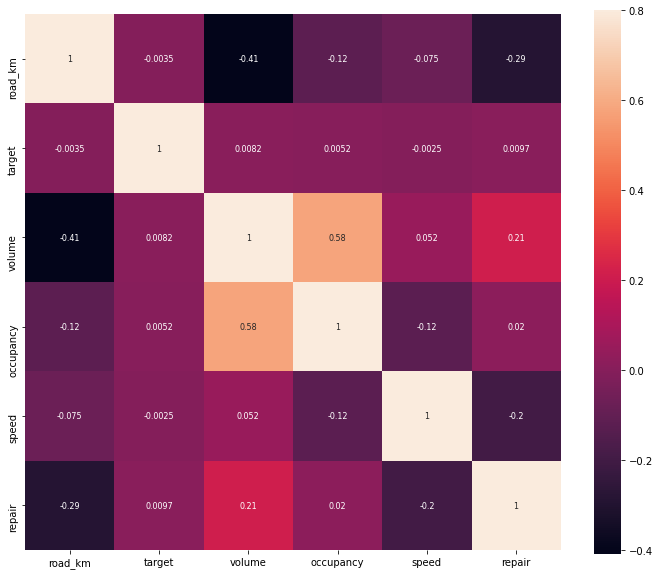

In [19]:
corrmat = tmp.corr()
f,ax = plt.subplots(figsize=(12,10))
sns.heatmap(corrmat,vmax=0.8,square=True,annot=True,annot_kws={'size':8})
plt.show()

### 2. Формирование модели. Обучение. Тестирование.

In [22]:
tmp['target'].value_counts()

0.0    686887
1.0       234
2.0        60
Name: target, dtype: int64

In [17]:
print("Нулевых значений переменной target: ", tmp[tmp['target'] == 0].shape[0])
print("Ненулевых значений переменной target: ", tmp[tmp['target'] != 0].shape[0])

Нулевых значений переменной target:  686887
Ненулевых значений переменной target:  294


In [18]:
# снизим объем выборки, рандомно удалив 98% строк с нулевыми значениями для target
tmp = tmp.drop(tmp[tmp['target'] == 0].sample(frac=.98).index)

In [19]:
tmp_train, tmp_test = train_test_split(tmp, test_size=0.2)
print("Размер выборки для обучения: ", tmp_train.shape)
print("Размер выборки для тестирования: ", tmp_test.shape)

Размер выборки для обучения:  (5730, 7)
Размер выборки для тестирования:  (1433, 7)


Выделим 20% всех данных на тестирование, остальные оставим на обучение

In [20]:
%%time
columns = ['volume',
           'occupancy',
           'speed',
           'repair']
tmp_train_x = tmp_train[columns]
tmp_train_y = tmp_train['target']

tmp_test_x = tmp_test[columns]
tmp_test_y = tmp_test['target']

clf = svm.SVC(gamma='auto', probability=True)
clf.fit(tmp_train_x, tmp_train_y)
predicted_target = clf.predict(tmp_test_x)

Wall time: 30.4 s


In [21]:
# оценим модель на тестово сэмпле
f1_score(tmp_test_y, predicted_target, average='macro')

0.32498807820696235

### 3. Проверка на основной тестовой выборке (предсказание)

In [22]:
# загрузка выборки
test = pd.read_csv('test.csv', parse_dates=['datetime'])
# выбор трассы М-8
test = test[test["road_id"]==9]

#### Обагащение выборки переменными из датасетов `traffic.csv`, `repair.csv`

In [23]:
# объединение выборки с данными о трафике
test = pd.merge(test, traffic, how='outer', on=['datetime', 'road_km','road_id'])
condition1 = (test['target'].isnull()) & (test['data_id'].isnull())
test = test.drop(test[condition1].index)
test.head(2)

,datetime,road_id,road_km,target,data_id,station_id,volume,occupancy,speed
38,2020-01-01 01:00:00,9,38,NaN,34604682.0,53224.0,87.0,1.0,114.671875
39,2020-01-01 01:00:00,9,38,NaN,34604682.0,53224.0,207.0,1.0,115.708435


In [24]:
# добавление данных о ремонте дороги на указанном километре
test['year'] = test['datetime'].map(lambda x: x.year)
repair['year'] = repair['datetime'].map(lambda x: x.year)

In [25]:
index_repair = test[test.set_index(['road_km','year']).index.isin(repair.set_index(['road_km','year']).index)].index
test.loc[index_repair, 'repair'] = 1
test['repair'] = test['repair'].fillna(0)
test.head()

,datetime,road_id,road_km,target,data_id,station_id,volume,occupancy,speed,year,repair
38,2020-01-01 01:00:00,9,38,NaN,34604682.0,53224.0,87.0,1.0,114.671875,2020,0.0
39,2020-01-01 01:00:00,9,38,NaN,34604682.0,53224.0,207.0,1.0,115.708435,2020,0.0
40,2020-01-01 01:00:00,9,38,NaN,34604682.0,53224.0,43.0,20.0,46.453125,2020,0.0
41,2020-01-01 01:00:00,9,38,NaN,34604682.0,53224.0,195.0,1.0,97.796875,2020,0.0
42,2020-01-01 01:00:00,9,38,NaN,34604682.0,53224.0,89.0,1.0,108.213440,2020,0.0


In [26]:
print("Размер выборки для тестирования: ", test.shape)

Размер выборки для тестирования:  (687181, 11)


In [27]:
# выбор переменных
columns = ['volume',
           'occupancy',
           'speed',
           'repair']

#### Предсказание и оценка модели

In [29]:
%%time
# предсказание значений переменной target
test['target'] =  clf.predict(test[columns])

Wall time: 4min 16s


In [30]:
prediction = test[['datetime','road_id','road_km','target']]
prediction.to_csv('prediction.csv', index=False)

In [37]:
# загрузка реальных данных тестовой выборки
test_secret = pd.read_csv('test_secret.csv', parse_dates=['datetime'])
# выбор трассы М-8
test_secret = test_secret[test_secret["road_id"]==9]

In [49]:
check = pd.merge(prediction, test_secret, how='left', on=['datetime', 'road_km','road_id'])
# сформируем выборку предсказанных занчений
check = check.drop(check[check['target_y'].isnull()].index)

In [50]:
check.head()

,datetime,road_id,road_km,target_x,target_y
0,2020-01-01 01:00:00,9,38,0.0,0.0
1,2020-01-01 01:00:00,9,38,0.0,0.0
2,2020-01-01 01:00:00,9,38,0.0,0.0
3,2020-01-01 01:00:00,9,38,0.0,0.0
4,2020-01-01 01:00:00,9,38,0.0,0.0


In [52]:
print("Кол-во предсказанных значений: ", check['target_x'].shape[0])
print("Кол-во фактических значений: ", check['target_y'].shape[0])

Кол-во предсказанных значений:  345193
Кол-во фактических значений:  345193


In [53]:
# оценка модели на реальных данных тестовой выборки 
f1_score(check['target_y'], check['target_x'], average='macro')

0.33304822488581165